In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
import numpy as np
import sklearn.neighbors as skn
from sklearn.linear_model import LinearRegression
import tqdm
from scipy.stats import norm
import json
import pandas as pd

In [2]:
import torch
import torch_geometric as pyg
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import sbi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('style.mcstyle')
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cpu


In [3]:
import ili
from ili.dataloaders import NumpyLoader, StaticNumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PosteriorCoverage
from ili.utils import IndependentTruncatedNormal, Uniform, IndependentNormal

from tools.plot_tools import binned_plot

In [4]:
def r2logm(r):
    # see preprocessing.ipynb for this measurement
    coef = 0.36752
    intercept = -5.30640
    return (np.log10(r)-intercept)/coef

## plot problem

In [5]:
datadir = './data/processed/AMICOdC100'

x_batch = np.load(join(datadir, 'x_batch.npy'), allow_pickle=True)
theta_batch = np.load(join(datadir, 'theta_batch.npy'), allow_pickle=True)

vcut = 1e3
def cut(x):
    return x[np.abs(x[:, 2]) < vcut]
x_batch = [cut(x) for x in x_batch]

def summ(x, weights=None):
    if weights is None:
        # gapper
        return np.sqrt(np.sum((x-np.mean(x))**2)/(len(x)-1))
    # weighted by PAMICO
    mu = np.sum(x*weights)/np.sum(weights)
    sig2 = np.sum(weights*(x-mu)**2)/np.sum(weights)
    return np.sqrt(sig2)

sigv = np.log10([summ(x[:, 2], x[:, 3]) for x in x_batch])

rich = np.log10([np.sum(x[:, 3]) for x in x_batch])

In [6]:
# run a linear regression and predict
lr = LinearRegression().fit(sigv.reshape(-1, 1), theta_batch[:,0])
theta_sigv = lr.predict(sigv.reshape(-1, 1))

lr = LinearRegression().fit(rich.reshape(-1, 1), theta_batch[:,0])
theta_rich = lr.predict(rich.reshape(-1, 1))

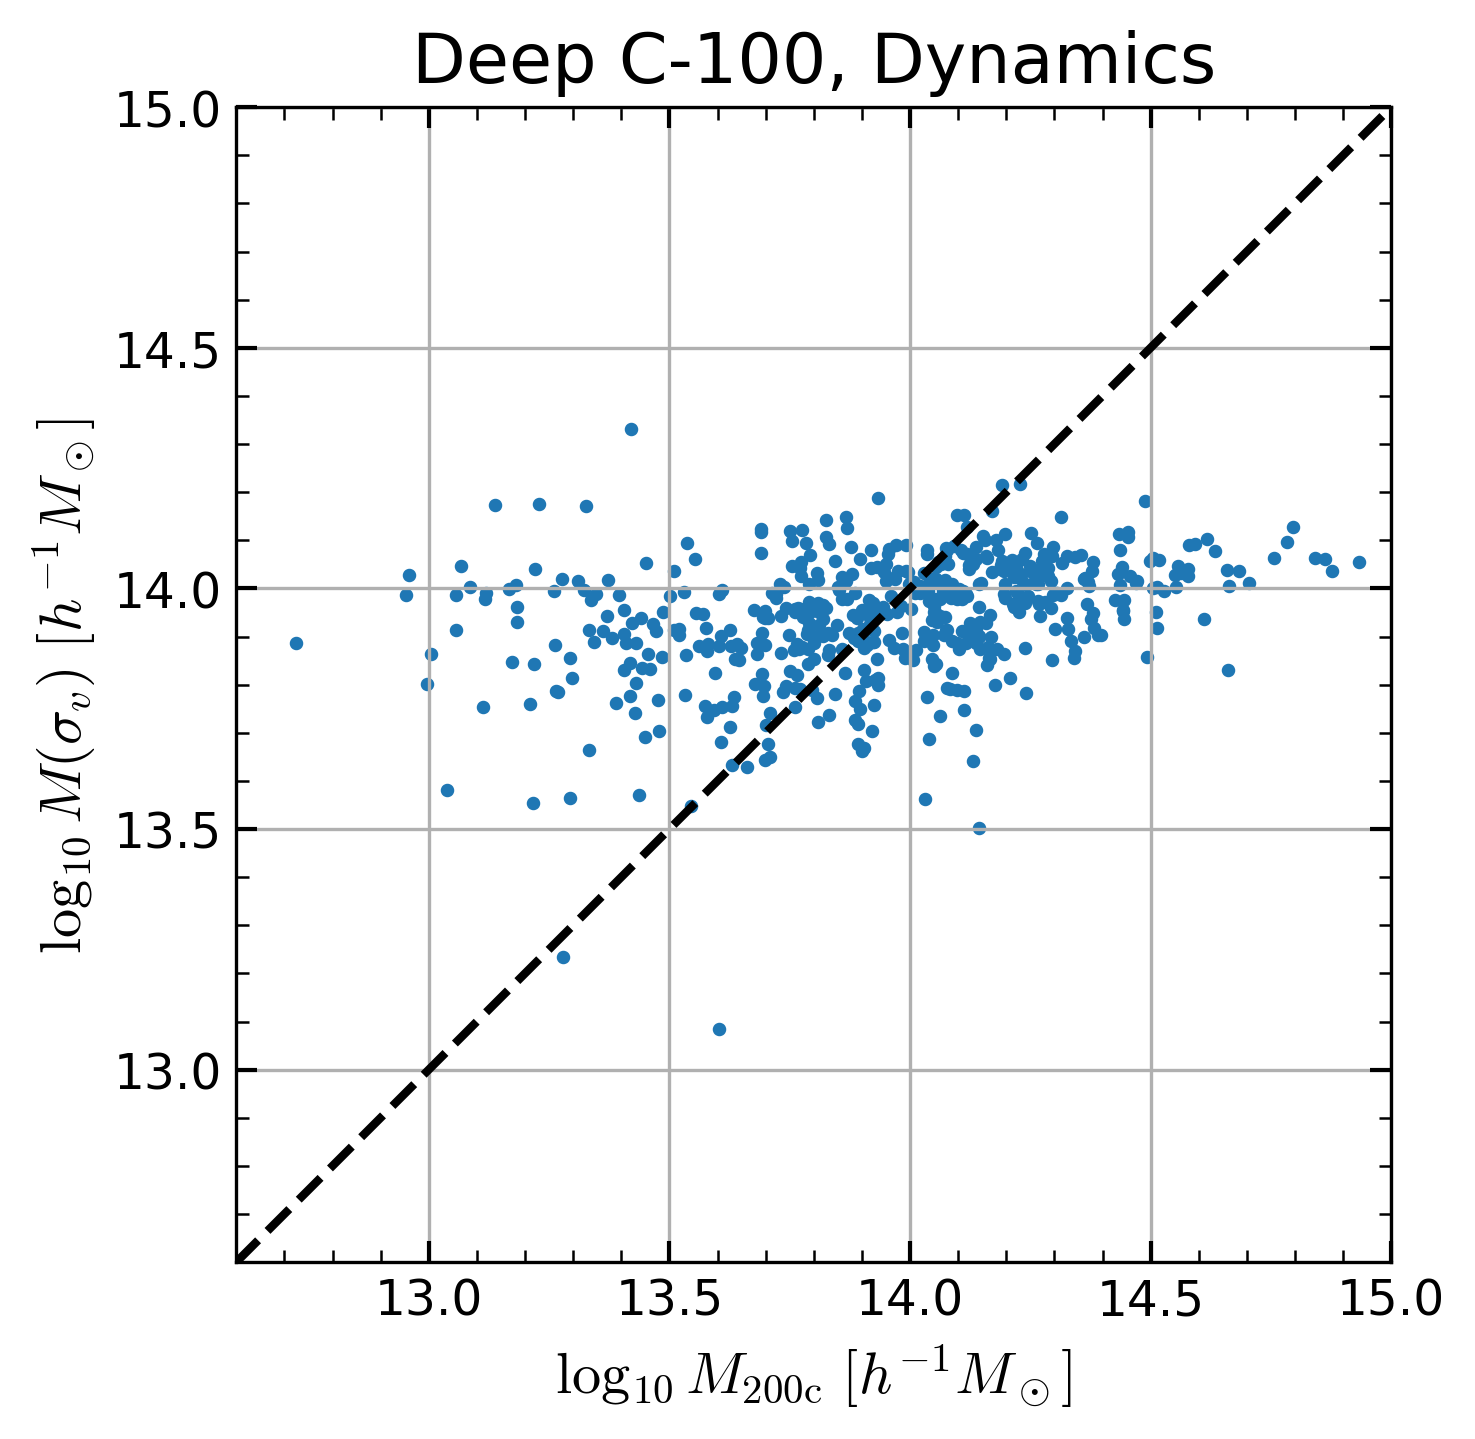

In [7]:
from sklearn.linear_model import LinearRegression
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot([12.6, 15], [12.6, 15], 'k--')
ax.scatter(theta_batch[:, 0], theta_sigv, s=5)
ax.set_xlabel(r'$\log_{10}M_{\rm 200c}\ [h^{-1}M_\odot]$')
ax.set_ylabel(r'$\log_{10}M(\sigma_v)\ [h^{-1}M_\odot]$')
ax.set_xlim(12.6, 15)
ax.set_ylim(12.6, 15)
ax.set_title(r'Deep C-100, Dynamics')
ax.set_aspect('equal')

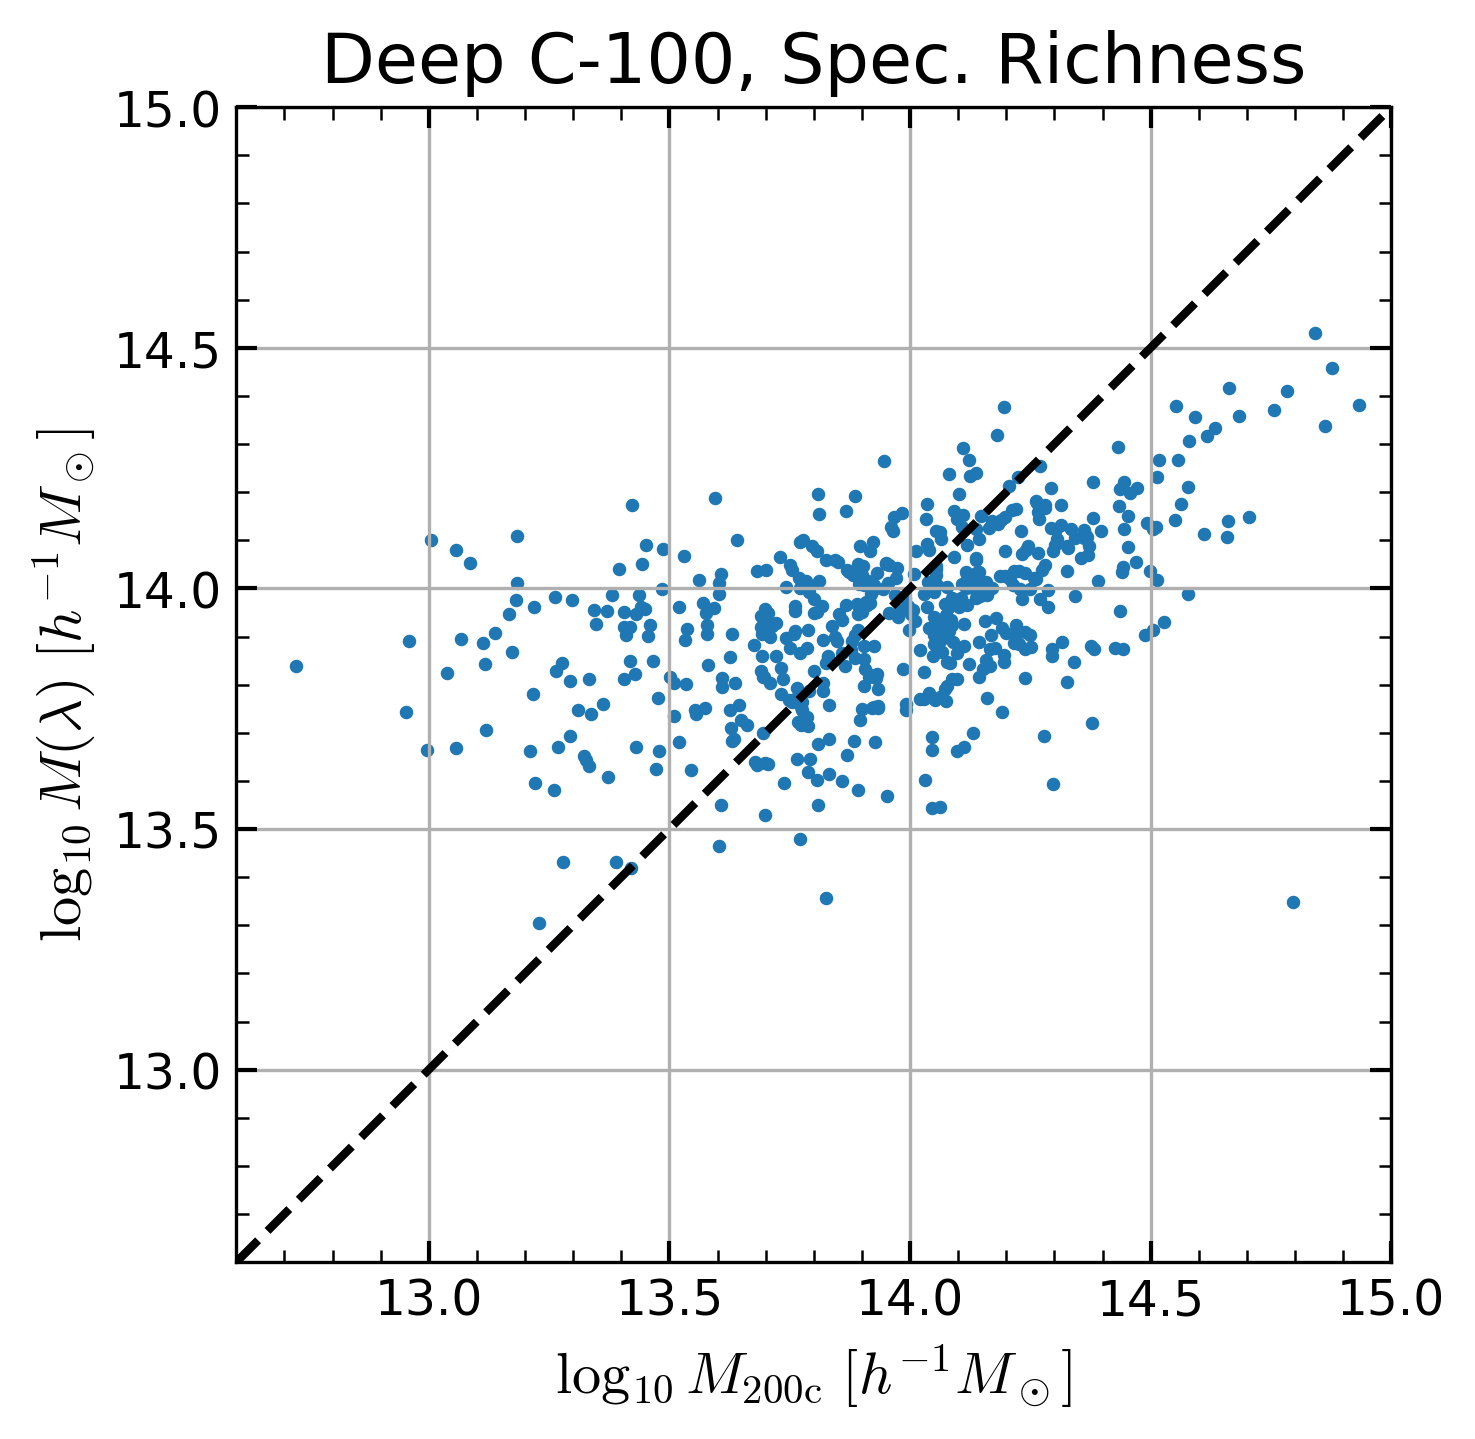

In [8]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot([12.6, 15], [12.6, 15], 'k--')
ax.scatter(theta_batch[:, 0], theta_rich, s=5)
ax.set_xlabel(r'$\log_{10}M_{\rm 200c}\ [h^{-1}M_\odot]$')
ax.set_ylabel(r'$\log_{10}M (\lambda)\ [h^{-1}M_\odot]$')
ax.set_xlim(12.6, 15)
ax.set_ylim(12.6, 15)
ax.set_title(r'Deep C-100, Spec. Richness')
ax.set_aspect('equal')



## plot diagnostics

In [9]:
datadir = './data/processed/AMICOdC100'

x_batch = np.load(join(datadir, 'x_batch.npy'), allow_pickle=True)
theta_batch = np.load(join(datadir, 'theta_batch.npy'), allow_pickle=True)

(-2.1, 2.1)

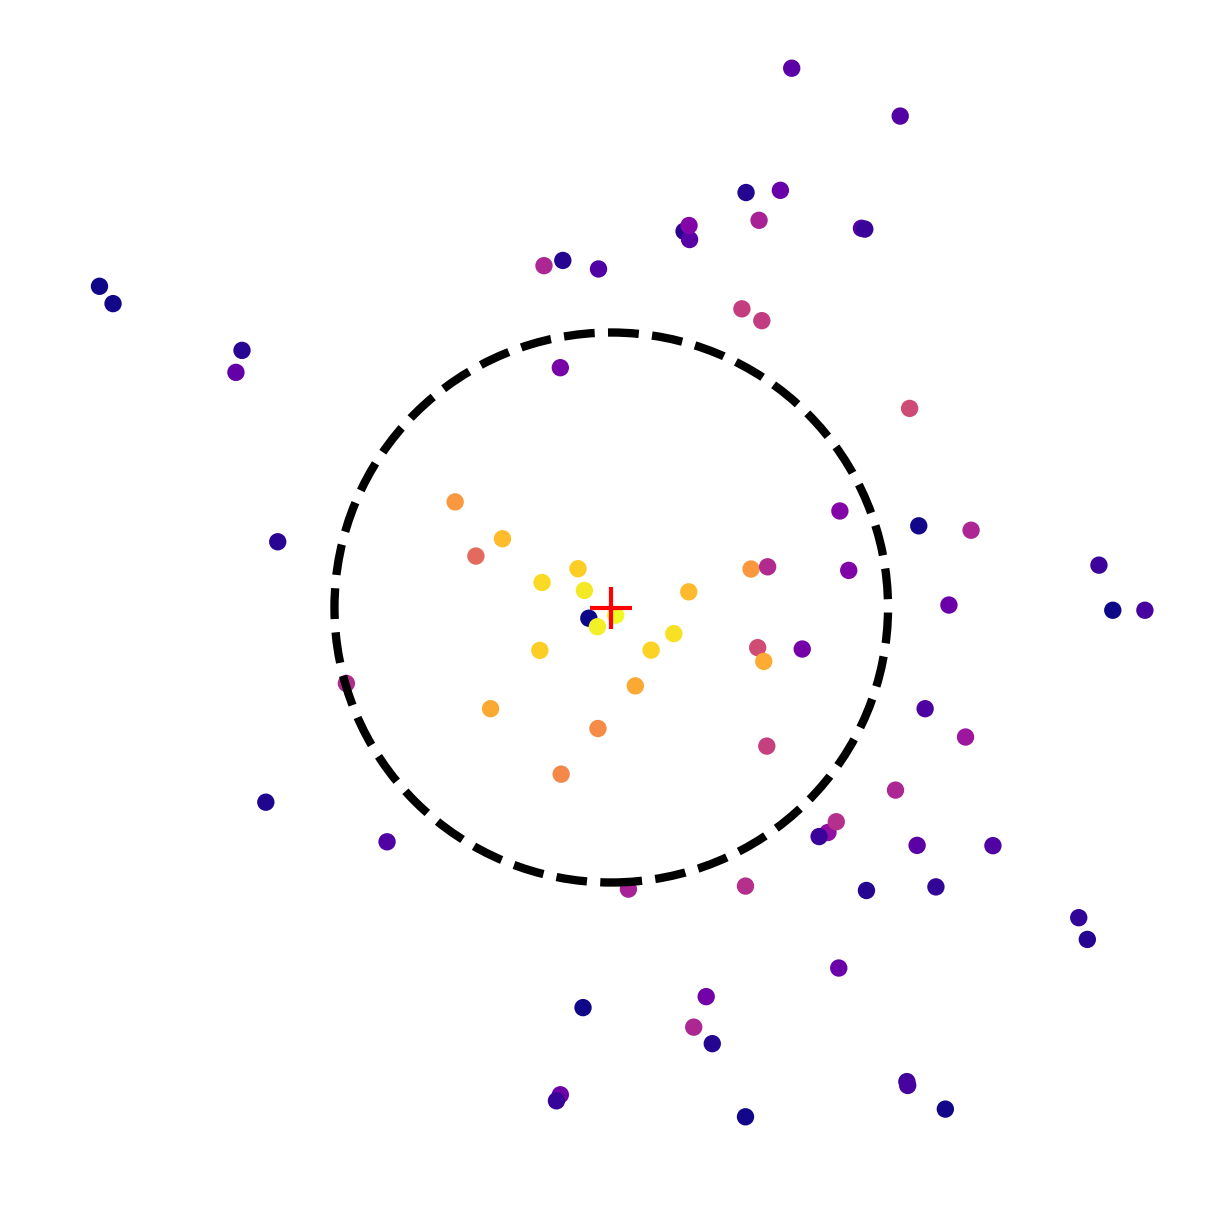

In [10]:
from matplotlib.patches import Circle
ind = np.random.randint(0, len(x_batch))
x_ = x_batch[ind]

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(0,0,'r+',ms=10)
ax.scatter(x_[:,0], x_[:,1], 
           c=x_[:,3], marker='o', s=10, 
           cmap='plasma', norm='linear',)
circle = Circle(
        (0, 0), radius=1, lw=2., edgecolor='black', 
        facecolor='none', linestyle='dashed')
ax.add_patch(circle)

        #    vmin=-5e3, vmax=5e3)
ax.set_axis_off()
ax.set_xlim(-2.1,2.1)
ax.set_ylim(-2.1,2.1)

## count gals

In [11]:
datasets = ['wC50', 'wC100', 'dC50', 'dC100']

for d in datasets:
    print('\n', d)
    datadir = f'./data/processed/AMICO{d}'
    t_ = np.load(join(datadir, 'theta_batch.npy'), allow_pickle=True)
    print(len(t_))
    t_ = np.load(join(datadir, 'theta.npy'), allow_pickle=True)
    print(len(t_))


 wC50
204
1559

 wC100
215
3062

 dC50
537
23866

 dC100
537
46217


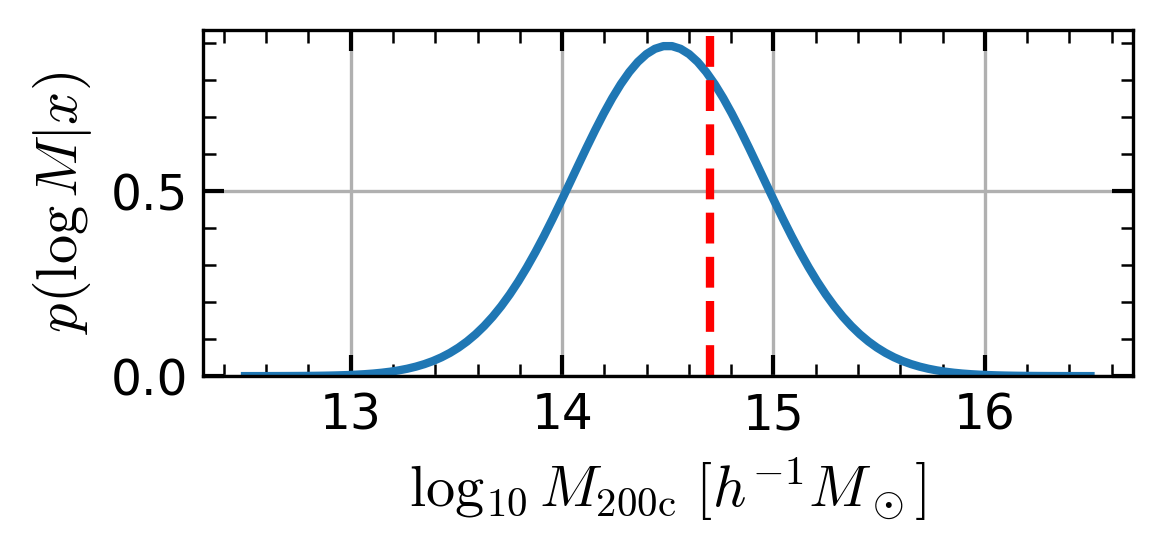

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the mean and variance
mean = 14.5
variance = 0.2

# Generate x values
x = np.linspace(mean-2, mean+2, 100)

# Calculate the Gaussian PDF
pdf = norm.pdf(x, mean, np.sqrt(variance))

# Plot the Gaussian PDF
f = plt.figure(figsize=(4,1.5))
plt.plot(x, pdf)
plt.axvline(mean+0.2, color='r', linestyle='--')
plt.xlabel(r'$\log_{10}M_{\rm 200c}\ [h^{-1}M_\odot]$')
plt.ylabel(r'$p( \log M | x)$')
plt.ylim(0)
# plt.title('Mass Posterior')
plt.show()


## plot true vs. predicted

In [13]:
models = ['msig', 'Pamico', 'summ_nle', 'gals_nle', 'gnn_npe']
datasets = ['wC50', 'wC100', 'dC50', 'dC100']
Nfolds = 10

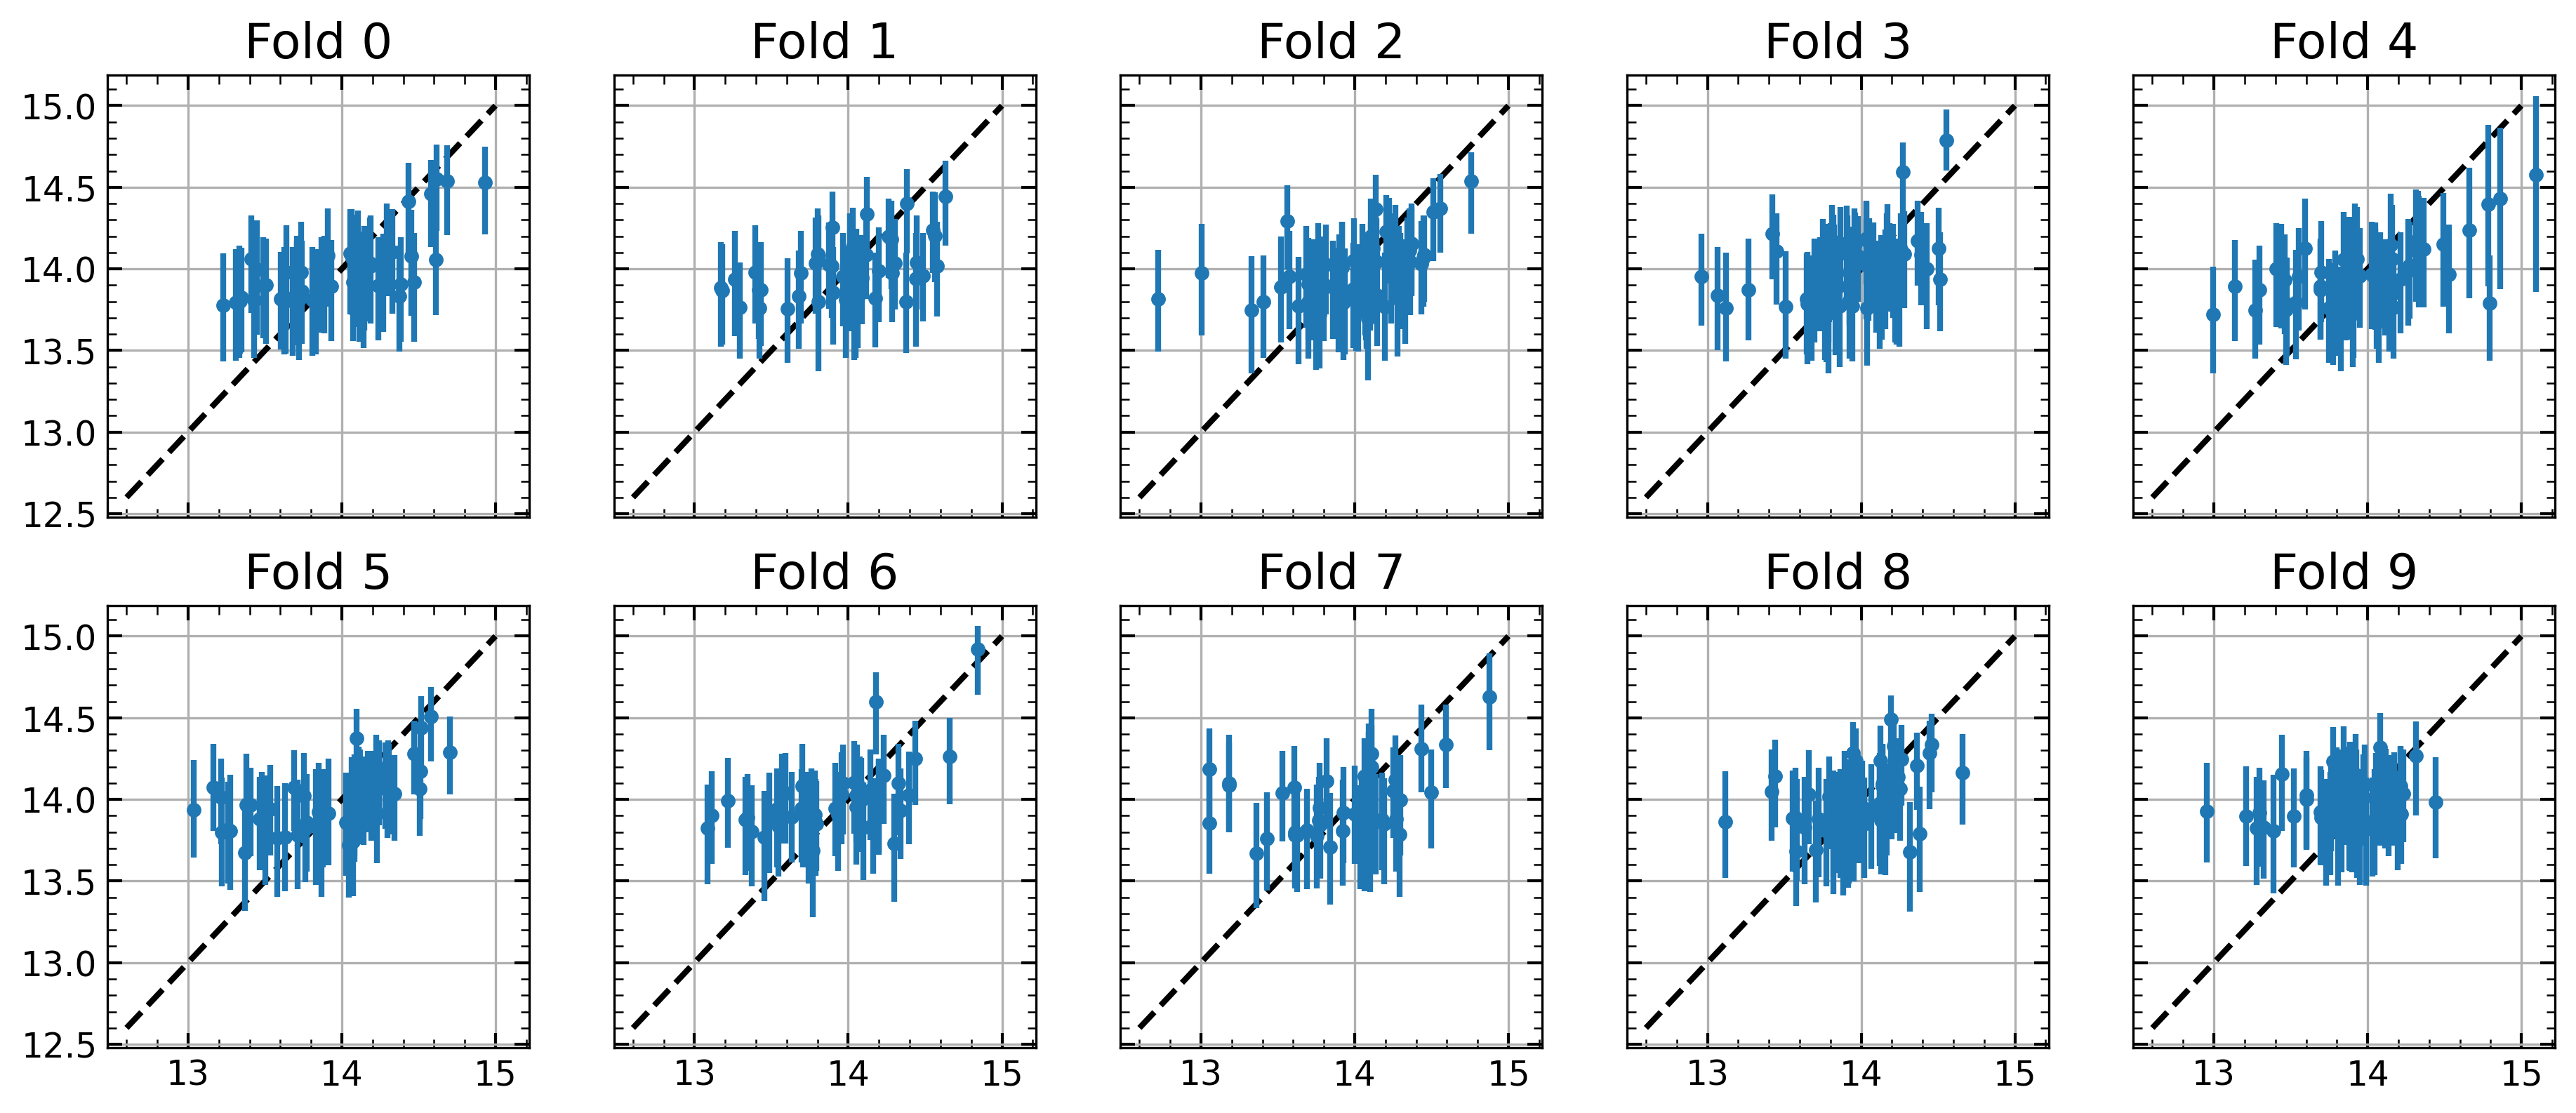

In [14]:
m = 'gnn_npe'
d = 'dC50'

Nrows = 2
Ncols = Nfolds // Nrows
f, axs = plt.subplots(Nrows, Ncols, figsize=(Ncols*3, Nrows*3), sharex=True, sharey=True)
axs=axs.flatten()


datadir = f'./data/processed/AMICO{d}'
theta = np.load(join(datadir, 'theta_batch.npy'), allow_pickle=True)
folds = np.load(join(datadir, 'folds_batch.npy'), allow_pickle=True)

for i in range(Nfolds):
    ax = axs[i]
    theta_fold = theta[folds == i]

    modeldir = f'./saved_models/{m}_{d}_f{i}'
    samps = np.load(join(modeldir, 'posterior_samples.npy'), allow_pickle=True)
    
    ax.plot([12.6, 15], [12.6, 15], 'k--')
    ps = np.percentile(samps, [16, 50, 84], axis=0)[...,0]
    ax.errorbar(theta_fold[:, 0], ps[1], yerr=[ps[1]-ps[0], ps[2]-ps[1]], fmt='o', ms=4)
    ax.set_title(f'Fold {i}')

In [15]:
titles = {
    'msig': r'$M-\sigma_v$',
    'Pamico': r'$M-\lambda$',
    'summ_nle': r'Summary-based',
    'gals_nle': r'Galaxy-based',
    'gnn_npe': r'Graph-based'
}

def measure_metrics(x, y):
    sig = np.std(x - y)
    rho = np.corrcoef(x, y)[0,1]
    frac = np.std(10**(x-y))
    return sig, rho, frac


In [25]:
prior = 13.94, 0.373

msig
Pamico
summ_nle
gals_nle
gnn_npe


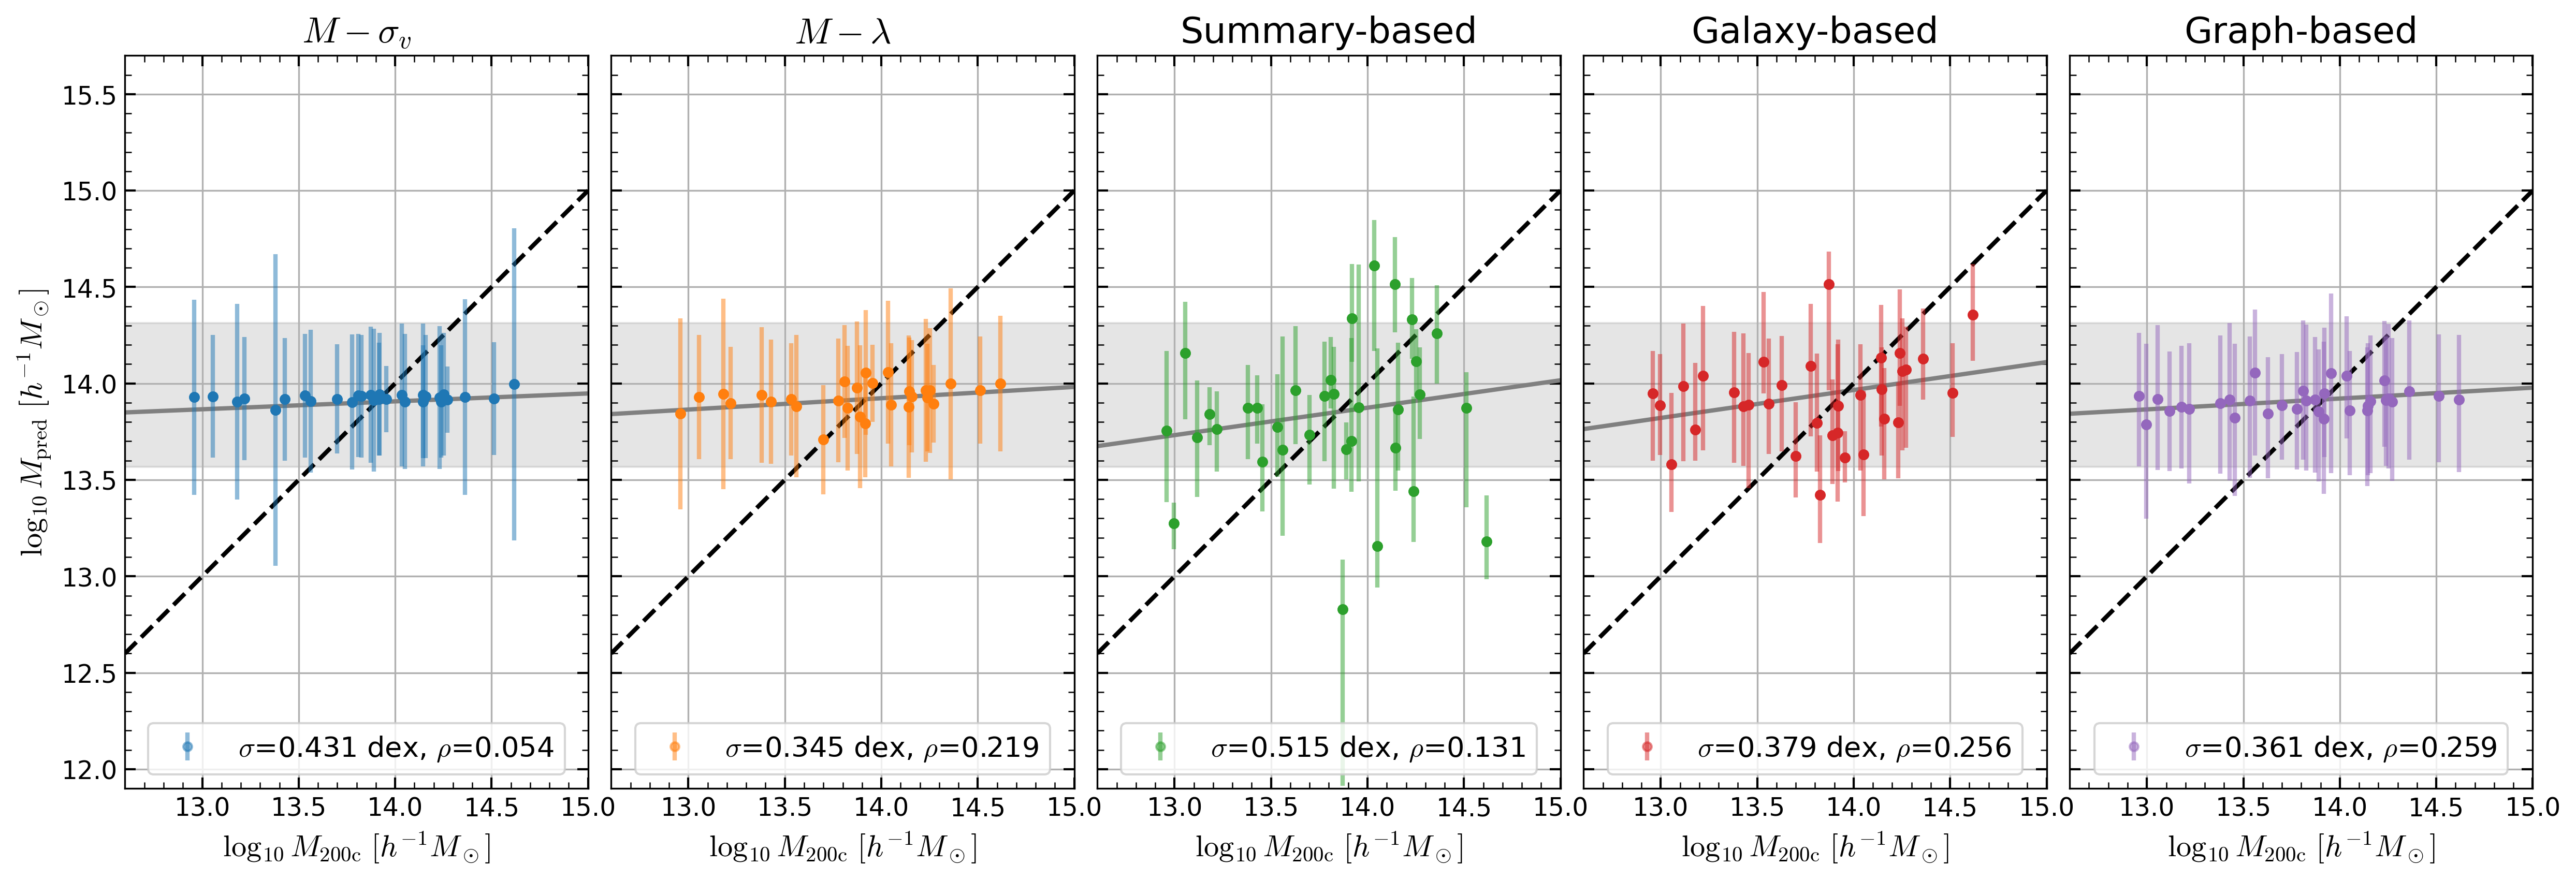

In [38]:
d = 'wC50'
Nsamp = 100

datadir = f'./data/processed/AMICO{d}'
ids = np.load(join(datadir, 'ids_batch.npy'), allow_pickle=True)
theta = np.load(join(datadir, 'theta_batch.npy'), allow_pickle=True)
folds = np.load(join(datadir, 'folds_batch.npy'), allow_pickle=True)

# theta_mask = np.random.choice(theta[:,0], Nsamp, replace=False)


f, axs = plt.subplots(1, len(models), figsize=(len(models)*4, 9), sharex=True, sharey=True,
                      gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for j, m in enumerate(models):
    print(m)
    ax = axs[j]
    
    p_ = []
    t_ = []
    for i in range(Nfolds):

        if m in ['msig', 'Pamico']:
            modeldir = f'./saved_models/base_{d}_f{i}'
            if not os.path.exists(join(modeldir, f'{m}.npz')):
                continue
            out = np.load(join(modeldir, f'{m}.npz'), allow_pickle=True)
            theta_fold = out['true']
            perc_fold = [out['pred']-out['std'], out['pred'], out['pred']+out['std']]
            perc_fold = np.stack(perc_fold, axis=0)[...,0].T
        else:
            modeldir = f'./saved_models/{m}_{d}_f{i}'
            if not os.path.exists(join(modeldir, 'posterior_samples.npy')):
                continue
            samps = np.load(join(modeldir, 'posterior_samples.npy'), allow_pickle=True)
            theta_fold = theta[folds == i]
            perc_fold = np.percentile(samps, [16, 50, 84], axis=0)[...,0].T
        p_.append(perc_fold)
        t_.append(theta_fold)

    p_ = np.concatenate(p_, axis=0)
    t_ = np.concatenate(t_, axis=0)

    # fit and plot a linear regression
    x_ = np.linspace(12.6, 15, 100)
    lr = LinearRegression().fit(t_[:, 0].reshape(-1, 1), p_[:, 1])
    y_ = lr.predict(x_.reshape(-1, 1))
    ax.plot(x_, y_, '-', color='gray')

    # measure correlation and scatter
    sig, rho, frac = measure_metrics(t_[:, 0], p_[:, 1])


    # only plot a subset of the points
    mask = np.isin(t_[:,0], theta_mask)
    p_ = p_[mask]
    t_ = t_[mask]

    ax.plot([12.6, 15], [12.6, 15], 'k--')
    ax.errorbar(t_[:, 0], p_[:, 1], yerr=[p_[:, 1]-p_[:, 0], p_[:, 2]-p_[:, 1]], 
                fmt='o', ms=4, color=f'C{j}', alpha=0.5,
                label=f'$\\sigma$={sig:.3f} dex, $\\rho$={rho:.3f}')
    ax.plot(t_[:, 0], p_[:, 1], 'o', ms=4, color=f'C{j}')
    ax.legend(fontsize=13, loc=8)
    ax.set_title(titles[m])
    ax.set_xlim(12.6, 15)
    ax.set_ylim(11.9, 15.7)
    ax.set_aspect('equal')
    ax.set_xlabel(r'$\log_{10}M_{\rm 200c}\ [h^{-1}M_\odot]$')
    if j == 0:
        ax.set_ylabel(r'$\log_{10}M_{\rm pred}\ [h^{-1}M_\odot]$')

    y_ = np.ones_like(x_)*prior[0]
    ax.fill_between(x_, y_-prior[1], y_+prior[1], color='gray', alpha=0.2)



In [40]:
models = models[2:]

summ_nle
gals_nle
gnn_npe


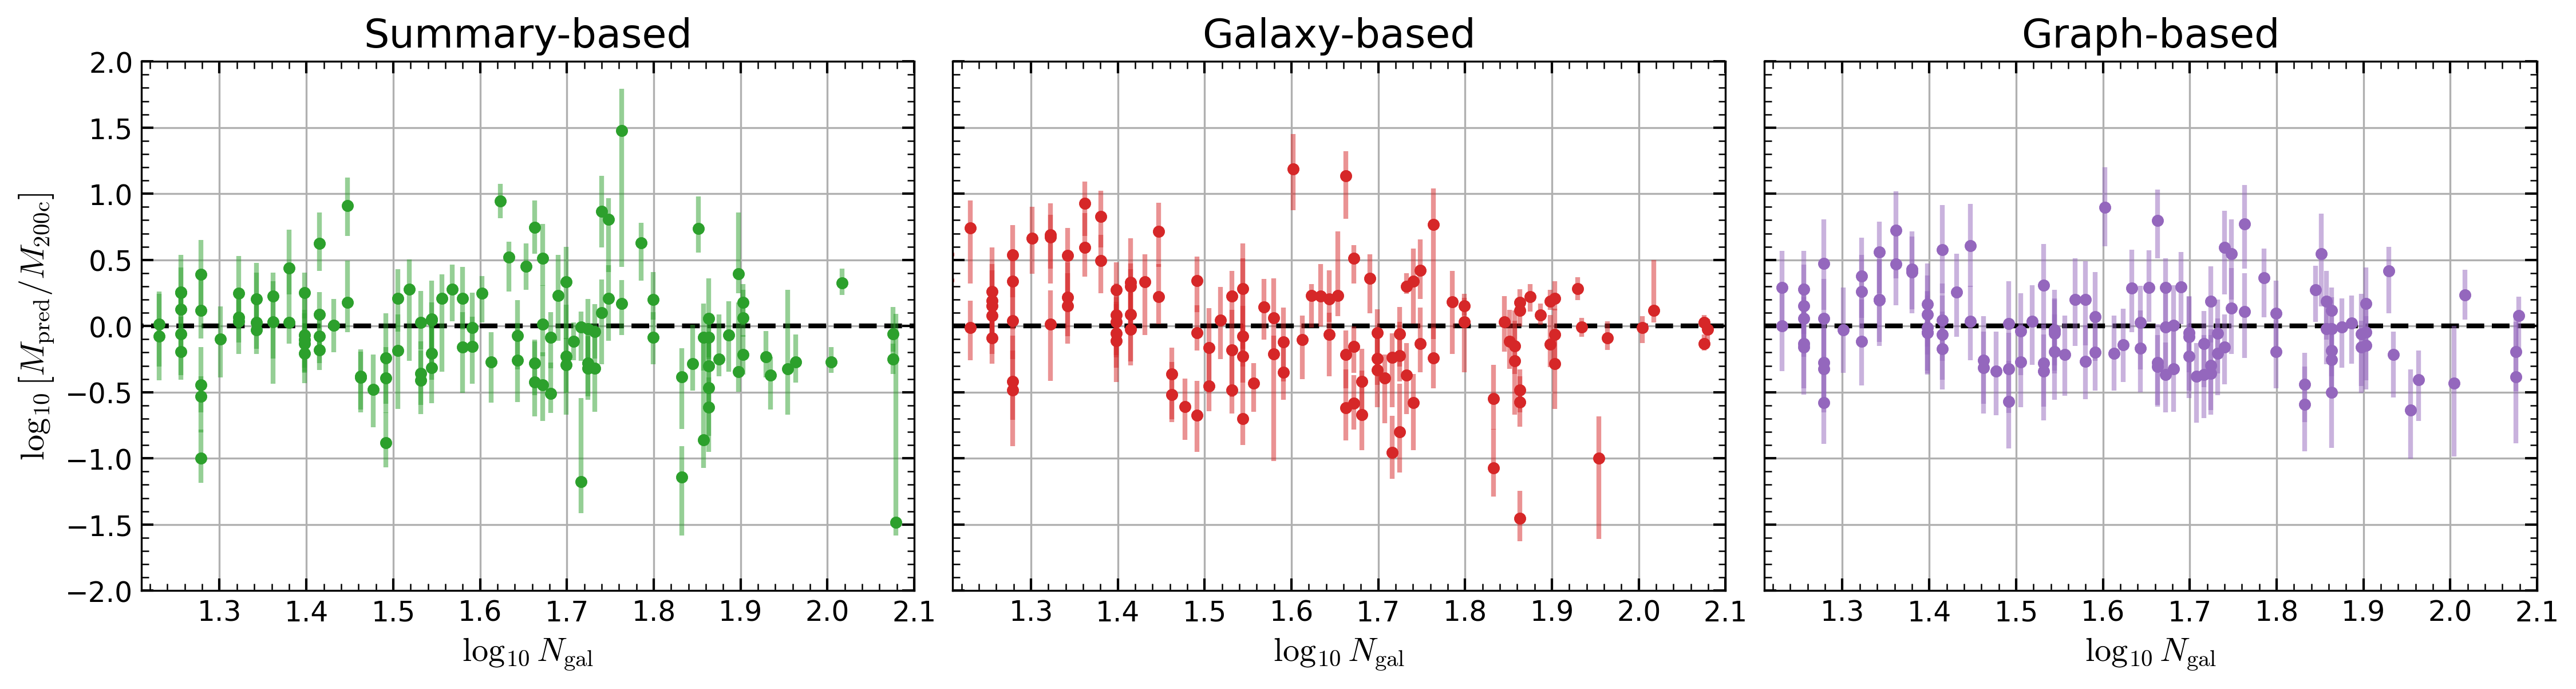

In [107]:
d = 'dC50'
Nsamp = 200

datadir = f'./data/processed/AMICO{d}'
ids = np.load(join(datadir, 'ids_batch.npy'), allow_pickle=True)
Ngal = np.load(join(datadir, 'x_batch.npy'), allow_pickle=True)
Ngal = np.log10(list(map(len, Ngal)))
theta = np.load(join(datadir, 'theta_batch.npy'), allow_pickle=True)
folds = np.load(join(datadir, 'folds_batch.npy'), allow_pickle=True)


# sample evenly across Ngal
be = np.histogram_bin_edges(Ngal, bins=10)
dig = np.digitize(Ngal, be)
theta_mask = []
for i in range(1, len(be)):
    mask = dig == i
    to_sample = Nsamp//10
    if np.sum(mask) < to_sample:
        to_sample = np.sum(mask)
    theta_mask.append(np.random.choice(theta[:,0][mask], to_sample, replace=False))

theta_mask = np.concatenate(theta_mask)


f, axs = plt.subplots(1, len(models), figsize=(len(models)*6, 4), sharex=True, sharey=True,
                      gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for j, m in enumerate(models):
    print(m)
    ax = axs[j]
    
    p_, t_, n_, i_ = [], [], [], []
    for i in range(Nfolds):

        if m in ['msig', 'Pamico']:
            continue
        else:
            modeldir = f'./saved_models/{m}_{d}_f{i}'
            if not os.path.exists(join(modeldir, 'posterior_samples.npy')):
                continue
            samps = np.load(join(modeldir, 'posterior_samples.npy'), allow_pickle=True)
            theta_fold = theta[folds == i]
            perc_fold = np.percentile(samps, [16, 50, 84], axis=0)[...,0].T
            Ngal_fold = Ngal[folds == i]
        p_.append(perc_fold)
        t_.append(theta_fold)
        n_.append(Ngal_fold)
        i_.append(ids[folds == i])

    p_ = np.concatenate(p_, axis=0)
    t_ = np.concatenate(t_, axis=0)
    n_ = np.concatenate(n_, axis=0)
    i_ = np.concatenate(i_, axis=0)

    # only plot a subset of the points
    mask = np.isin(t_[:,0], theta_mask)
    p_ = p_[mask]
    t_ = t_[mask]
    n_ = n_[mask]
    i_ = i_[mask]

    # calculate error
    p_ -= t_

    ax.plot([1,3], [0,0], 'k--')
    ax.errorbar(n_, p_[:, 1], yerr=[p_[:, 1]-p_[:, 0], p_[:, 2]-p_[:, 1]], 
                fmt='o', ms=4, color=f'C{j+2}', alpha=0.5)
    ax.plot(n_, p_[:, 1], 'o', ms=4, color=f'C{j+2}')
    ax.set_title(titles[m])
    ax.set_xlabel(r'$\log_{10}N_{\rm gal}$')
    ax.set_xlim(1.21, 2.1)
    ax.set_ylim(-2,2)
    if j == 0:
        ax.set_ylabel(r'$\log_{10}\left[M_{\rm pred}/M_{\rm 200c}\right]$')



In [86]:
# load additional cluster metadata
data = pd.read_csv(
    'data/raw/deep_all_AMICO.dat', delimiter=' ', index_col=False,
    skipinitialspace=True)
data = pd.DataFrame(
    data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)
data['Cl_id'] = data['Cl_id'].astype(int)
data.set_index('Cl_id', inplace=True)

summ_nle
gals_nle
gnn_npe


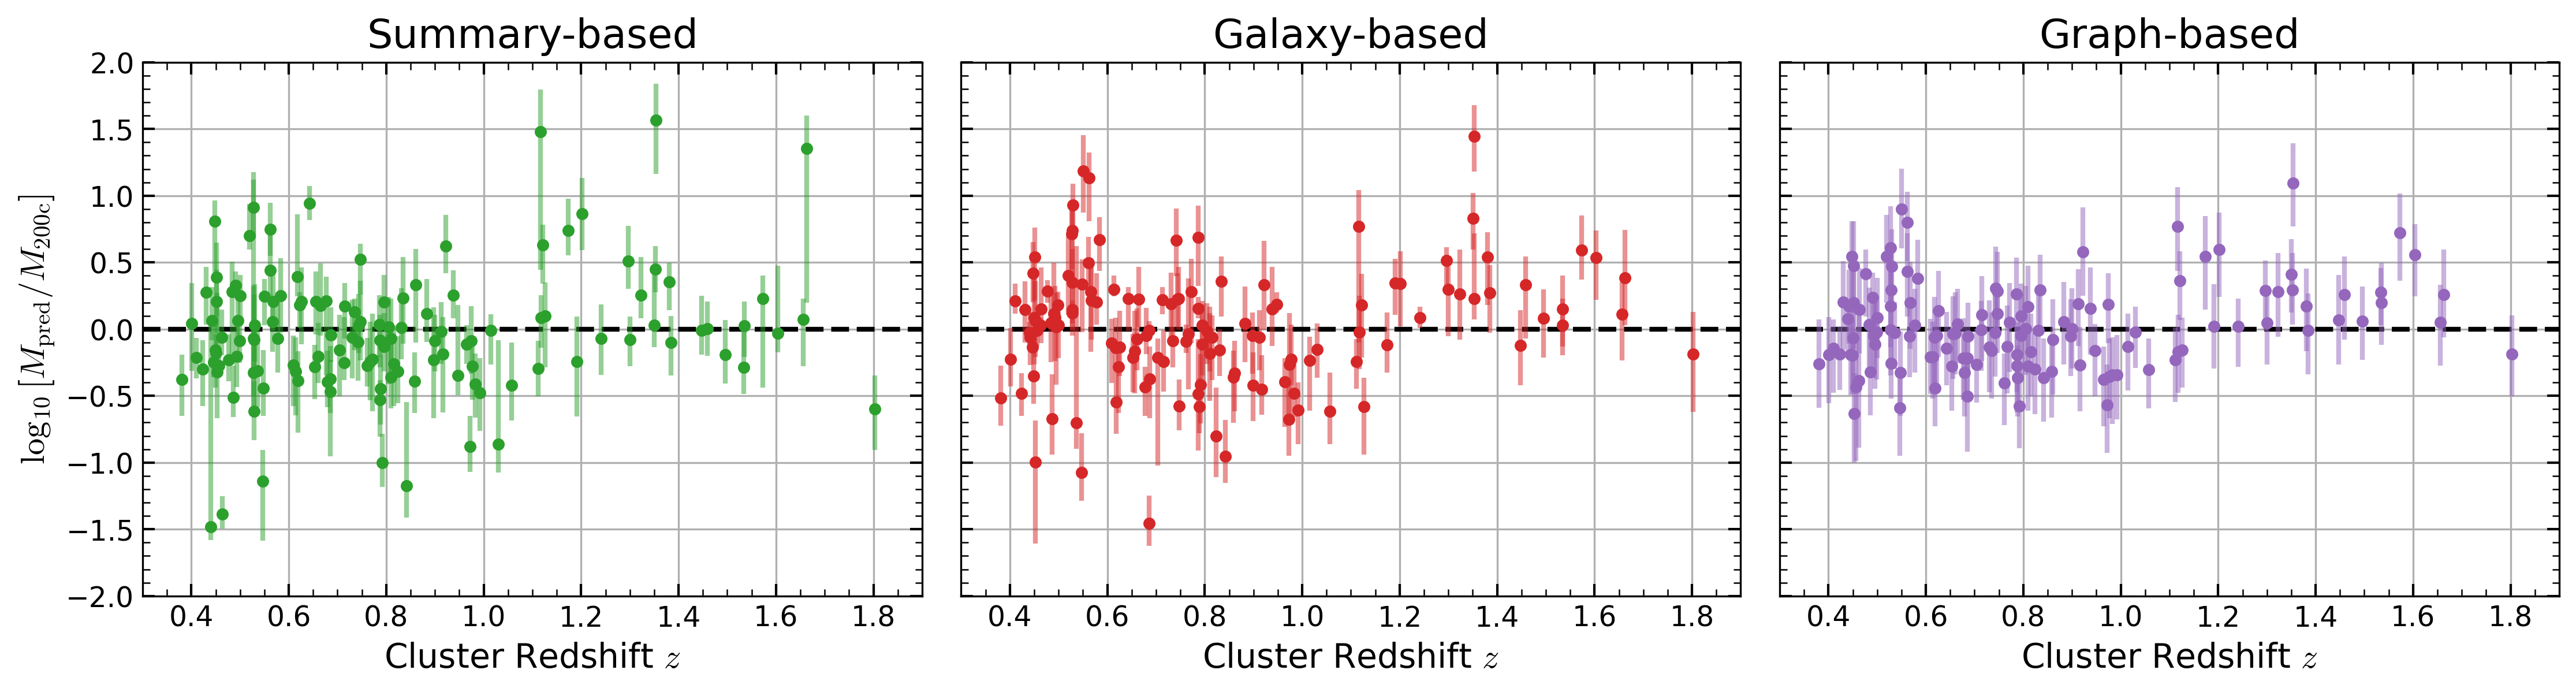

In [112]:
d = 'dC50'
# Nsamp = 100

datadir = f'./data/processed/AMICO{d}'
ids = np.load(join(datadir, 'ids_batch.npy'), allow_pickle=True)
Ngal = np.load(join(datadir, 'x_batch.npy'), allow_pickle=True)
Ngal = np.log10(list(map(len, Ngal)))
theta = np.load(join(datadir, 'theta_batch.npy'), allow_pickle=True)
folds = np.load(join(datadir, 'folds_batch.npy'), allow_pickle=True)

# theta_mask = np.random.choice(theta[:,0], Nsamp, replace=False)


f, axs = plt.subplots(1, len(models), figsize=(len(models)*6, 4), sharex=True, sharey=True,
                      gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for j, m in enumerate(models):
    print(m)
    ax = axs[j]
    
    p_, t_, n_, i_ = [], [], [], []
    for i in range(Nfolds):

        if m in ['msig', 'Pamico']:
            continue
        else:
            modeldir = f'./saved_models/{m}_{d}_f{i}'
            if not os.path.exists(join(modeldir, 'posterior_samples.npy')):
                continue
            samps = np.load(join(modeldir, 'posterior_samples.npy'), allow_pickle=True)
            theta_fold = theta[folds == i]
            perc_fold = np.percentile(samps, [16, 50, 84], axis=0)[...,0].T
            Ngal_fold = Ngal[folds == i]
        p_.append(perc_fold)
        t_.append(theta_fold)
        n_.append(Ngal_fold)
        i_.append(ids[folds == i])

    p_ = np.concatenate(p_, axis=0)
    t_ = np.concatenate(t_, axis=0)
    n_ = np.concatenate(n_, axis=0)
    i_ = np.concatenate(i_, axis=0)

    # only plot a subset of the points
    mask = np.isin(t_[:,0], theta_mask)
    p_ = p_[mask]
    t_ = t_[mask]
    n_ = n_[mask]
    i_ = i_[mask]

    # get redshifts
    z_ = data['zctrue'].drop_duplicates().loc[i_]

    # calculate error
    p_ -= t_

    ax.plot([0.3,2], [0,0], 'k--')
    ax.errorbar(z_, p_[:, 1], yerr=[p_[:, 1]-p_[:, 0], p_[:, 2]-p_[:, 1]], 
                fmt='o', ms=4, color=f'C{j+2}', alpha=0.5)
    ax.plot(z_, p_[:, 1], 'o', ms=4, color=f'C{j+2}')
    ax.set_title(titles[m])
    ax.set_xlabel(r'Cluster Redshift $z$')
    ax.set_xlim(0.3, 1.9)
    ax.set_ylim(-2,2)
    if j == 0:
        ax.set_ylabel(r'$\log_{10}\left[M_{\rm pred}/M_{\rm 200c}\right]$')



In [99]:
data['zctrue'].drop_duplicates().loc[i_].shape, i_.shape, z_.shape

((131,), (131,), (22535,))

Cl_id
1001     1.57325
1002    0.478922
1003     1.20453
1004     1.05585
1005    0.676542
          ...   
991     0.885013
996      1.34028
997     0.725212
99       1.12022
9       0.462526
Name: zctrue, Length: 537, dtype: object